In [25]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Change to use continuous adjoint method
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import application_examples.helpers.plotting as plt

In [88]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# Learning a linear system

## Model 1: Can we approximate the vector field with a simple neural network?

### Hyperparameters

In [94]:
method  = 'dopri5'
data_size = 5000
batch_time = 25
batch_size = 100
niters = 5000
test_freq = 20
terminal_time = 25.
learning_rate = 1e-4
# Stopping variables
eps = 1e-2
tol = 1

### The data

In order to train the model, let's create a "real" system to use as training data. 

In [95]:
t = torch.linspace(0., terminal_time, data_size)


#### Define the real system
First define the real system, which is a linear system of ODEs with a known solution. Then calculate the solution of the system using the `odeint` function from `torchdiffeq` and plot the solution.

In [96]:
true_y0 = torch.tensor([[2., 0.]])
true_A = torch.tensor([[-0.1, 3.0], [-3.0, -0.1]])

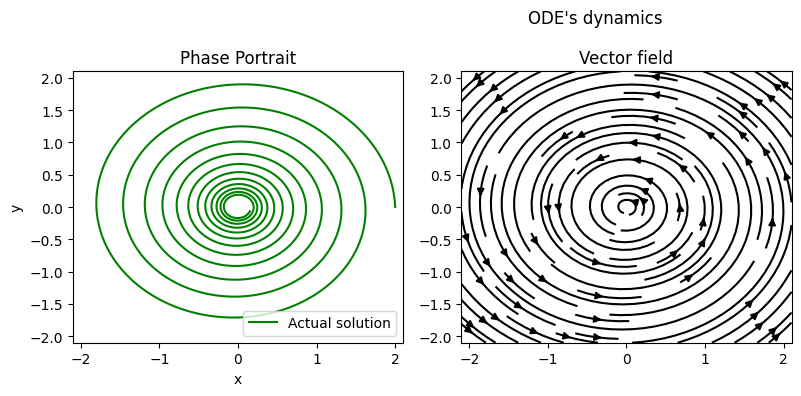

In [97]:
true_vector_field = lambda t, y: torch.mm(y, true_A)
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')
plt.plot_ode(true_y, true_vector_field)

### The model

In [98]:
# Define a Neural Network to learn the vector field
class ODEnn(nn.Module):

    def __init__(self):
        super(ODEnn, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODEnn()

#### Train the neural network

In [99]:
def get_batch(true_y, t): # TODO put this in helpers
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [100]:
# TODO add training function in helpers
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

losses = [] # List that will store the loss at each iteration

for i in range(niters):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(true_y, t)
    pred_y = odeint(func, batch_y0, batch_t, method=method)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    # Visualise training process
    if i % test_freq == 0:
        with torch.no_grad():
            # Compute loss using all data
            pred_y = odeint(func, true_y0, t, method=method)
            loss = torch.norm(pred_y - true_y)
            losses.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            
# Compute loss using all data
pred_y = odeint(func, true_y0, t, method=method)
loss = torch.norm(pred_y - true_y)
losses.append(loss.item())
print('Iter {:04d} | Total Final Loss {:.6f}'.format(niters, loss.item()))
    

Iter 0000 | Total Loss 560.444702
Iter 0020 | Total Loss 373.751770
Iter 0040 | Total Loss 254.053116
Iter 0060 | Total Loss 151.748993
Iter 0080 | Total Loss 97.497078
Iter 0100 | Total Loss 95.601700
Iter 0120 | Total Loss 106.174980
Iter 0140 | Total Loss 109.857811
Iter 0160 | Total Loss 108.285973
Iter 0180 | Total Loss 101.693359
Iter 0200 | Total Loss 98.448265
Iter 0220 | Total Loss 97.606865
Iter 0240 | Total Loss 98.055641
Iter 0260 | Total Loss 97.694130
Iter 0280 | Total Loss 96.536469
Iter 0300 | Total Loss 95.065857
Iter 0320 | Total Loss 93.162338
Iter 0340 | Total Loss 92.679543
Iter 0360 | Total Loss 92.145767
Iter 0380 | Total Loss 91.696548
Iter 0400 | Total Loss 91.112274
Iter 0420 | Total Loss 90.545547
Iter 0440 | Total Loss 89.846863
Iter 0460 | Total Loss 89.084908
Iter 0480 | Total Loss 88.502235
Iter 0500 | Total Loss 88.485344
Iter 0520 | Total Loss 88.010994
Iter 0540 | Total Loss 87.500366
Iter 0560 | Total Loss 87.169868
Iter 0580 | Total Loss 86.903748
It

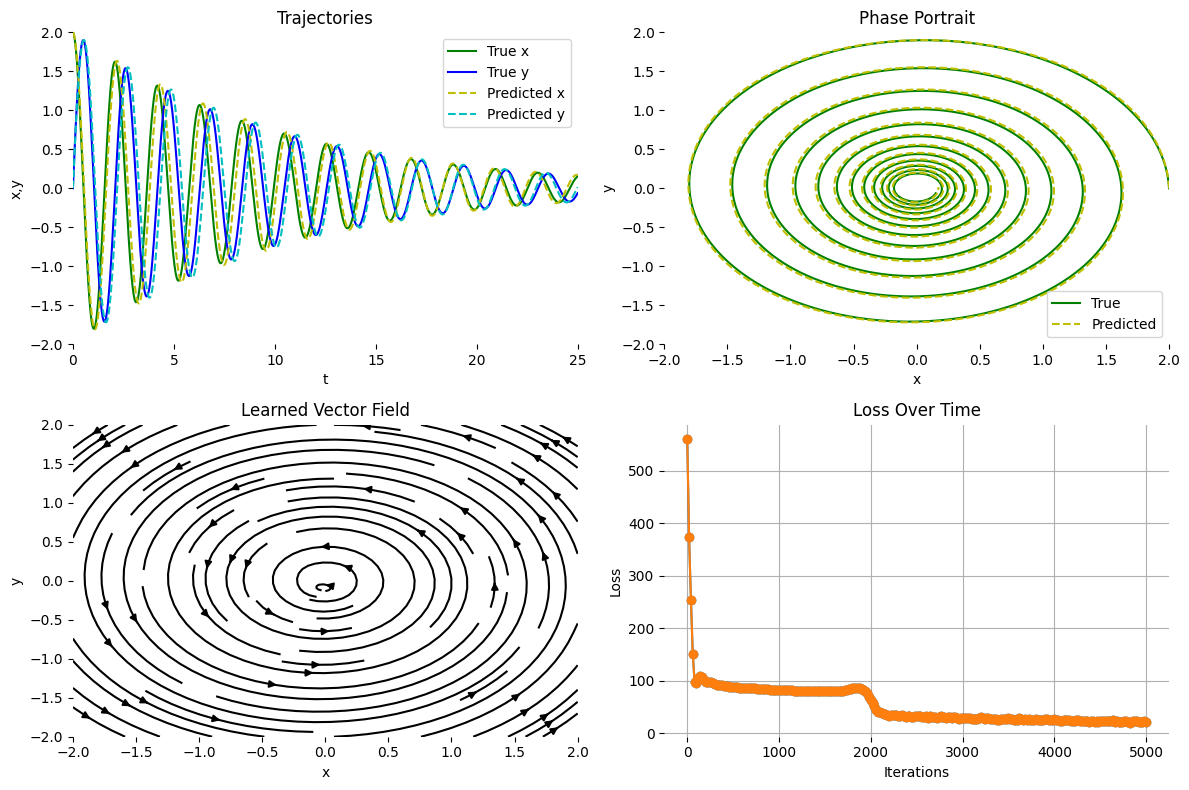

In [101]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=method), t, func, losses, test_freq)

### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [81]:
# Double time and data points
test_t = torch.linspace(0., 2 * terminal_time, 2 * data_size)

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method='dopri5')

Total Test Loss 1.527795


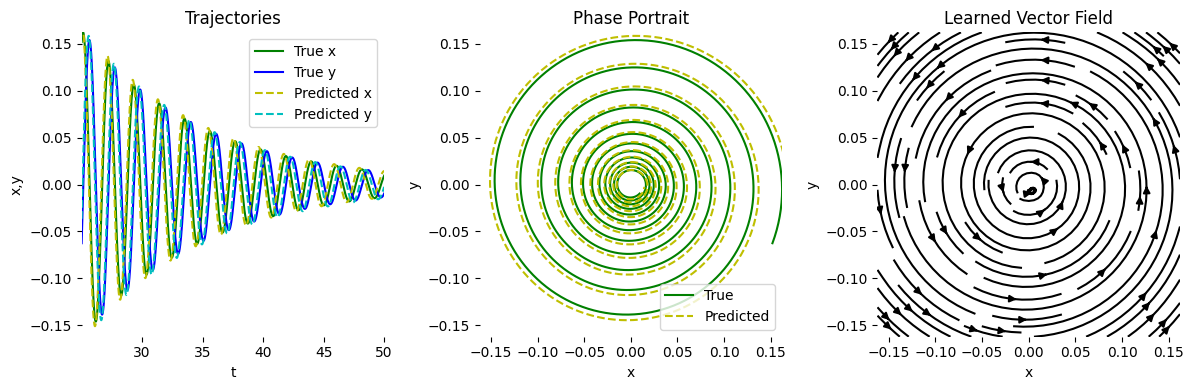

In [82]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=method) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-data_size:] - test_true_y[-data_size:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-data_size:], odeint(func, true_y0, test_t, method=method)[-data_size:], test_t[-data_size:], func)

It is expected that the loss will be smaller because the points are much closer together. However, when looking at the graph one can appreciate the solution goes faster than the actual system.

Actually, it seems the model is not able to learn the vector trajectory of the solution with much precision after some time. 

### Can the model train with a different initial condition?

In this section we define a different $y_0$ and train the model again.

In [36]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [37]:
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

new_losses = [] # List that will store the loss at each iteration

for i in range(niters):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(new_true_y, t)
    new_pred_y = odeint(func, batch_y0, batch_t, method=method)
    loss = torch.norm(new_pred_y - batch_y)
    loss.backward()
    optimizer.step()

    # Visualise training process
    if i % test_freq == 0:
        with torch.no_grad():
            # Compute loss using all data
            new_pred_y = odeint(func, new_true_y0, t, method=method)
            loss = torch.norm(new_pred_y - new_true_y)
            new_losses.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            
# Compute loss using all data
new_pred_y = odeint(func, new_true_y0, t, method=method)
loss = torch.norm(new_pred_y - new_true_y)
new_losses.append(loss.item())
print('Iter {:04d} | Total Final Loss {:.6f}'.format(niters, loss.item()))

Iter 0000 | Total Loss 496.719604
Iter 0020 | Total Loss 449.393555
Iter 0040 | Total Loss 428.067352
Iter 0060 | Total Loss 432.273071
Iter 0080 | Total Loss 446.631439
Iter 0100 | Total Loss 459.674133
Iter 0120 | Total Loss 472.541077
Iter 0140 | Total Loss 484.594696
Iter 0160 | Total Loss 494.329010
Iter 0180 | Total Loss 501.669098
Iter 0200 | Total Loss 507.475220
Iter 0220 | Total Loss 510.411469
Iter 0240 | Total Loss 512.499451
Iter 0260 | Total Loss 514.242859
Iter 0280 | Total Loss 514.793091
Iter 0300 | Total Loss 513.819641
Iter 0320 | Total Loss 514.269348
Iter 0340 | Total Loss 512.866699
Iter 0360 | Total Loss 512.949646
Iter 0380 | Total Loss 511.909210
Iter 0400 | Total Loss 509.408447
Iter 0420 | Total Loss 509.022888
Iter 0440 | Total Loss 508.076294
Iter 0460 | Total Loss 504.869812
Iter 0480 | Total Loss 504.930664
Iter 0500 | Total Loss 505.530640
Iter 0520 | Total Loss 507.903778
Iter 0540 | Total Loss 506.838470
Iter 0560 | Total Loss 506.123627
Iter 0580 | To

KeyboardInterrupt: 

In [ ]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=method), t, func, new_losses, test_freq)

Observe that the results are considerably worse. This is because the vector field has much larger values in the vicinity of the new initial condition. Not only does this cause the error, in general, to be much larger, but it also makes the system more sensitive to small discrepancies in the predicted points, which add up to a large error.

## Model 2: Can we improve the results by simplifying the model?
This is a very simple system. In fact it the vector field we are trying to learn is linear. Therefore, the neural network doesn't need to be able to learn a non-linear function. Let's try to simplify the model by removing the hidden layer and the activation function and reducing the number of neurons in the hidden layer.

### New hyperparameters

In [ ]:
data_size = 5000
batch_time = 10
batch_size = 100
niters = 25000
test_freq = 50
terminal_time = 25.
learning_rate = 1e-4

### The data

In [ ]:
t = torch.linspace(0., terminal_time, data_size)


In [ ]:
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')

### The model

In [ ]:
# Define a Neural Network to learn the vector field
class ODELin(nn.Module):

    def __init__(self):
        super(ODELin, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 2 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 4),
            nn.Linear(4, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODELin()

#### Train the neural network

In [ ]:
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

losses = [] # List that will store the loss at each iteration
prev_loss = float('inf')

for i in range(niters):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(true_y, t)
    pred_y = odeint(func, batch_y0, batch_t, method=method)
    loss = torch.norm(pred_y - batch_y)
    loss.backward()
    optimizer.step()

    # Visualise training process
    if i % test_freq == 0:
        with torch.no_grad():
            # Compute loss using all data
            pred_y = odeint(func, true_y0, t, method=method)
            loss = torch.norm(pred_y - true_y)
            losses.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            if (abs(loss.item() - prev_loss) < eps and loss.item() < tol) or (loss.item() < eps):
                break
            prev_loss = loss.item()
            
# Compute loss using all data
pred_y = odeint(func, true_y0, t, method=method)
loss = torch.norm(pred_y - true_y)
losses.append(loss.item())
print('Total Final Loss {:.6f}'.format(loss.item()))
    

In [ ]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=method), t, func, losses, test_freq)

### Try it with a different initial condition

In [ ]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [ ]:
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

new_losses = [] # List that will store the loss at each iteration

for i in range(niters):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(new_true_y, t)
    new_pred_y = odeint(func, batch_y0, batch_t, method=method)
    loss = torch.norm(new_pred_y - batch_y)
    loss.backward()
    optimizer.step()

    # Visualise training process
    if i % test_freq == 0:
        with torch.no_grad():
            # Compute loss using all data
            new_pred_y = odeint(func, new_true_y0, t, method=method)
            loss = torch.norm(new_pred_y - new_true_y)
            new_losses.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            
# Compute loss using all data
new_pred_y = odeint(func, new_true_y0, t, method=method)
loss = torch.norm(new_pred_y - new_true_y)
new_losses.append(loss.item())
print('Total Final Loss {:.6f}'.format(loss.item()))

In [ ]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=method), t, func, new_losses, test_freq)

## Results
It turns out that the new simplified model works much better in this case. Even when learning with the harder initial condition, the model is able to learn the vector field and predict the solution of the system with precision.